In [396]:
from __future__ import division
from __future__ import print_function
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle
pd.options.mode.chained_assignment = None  # default='warn'

In [397]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [268]:
# File with gender included
sample10_file = '/Users/lekha/galvanize/capstone/projectRiley/data/sample10/out.txt'
sample1000_file = '/Users/lekha/galvanize/capstone/projectRiley/data/cleandatagender1000.txt'
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/cleandatagenderall.txt'

uwash_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_huskies.txt'
holyoke_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_holyoke.txt'
utaustin_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_utaustin.txt'
gatech_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_gatech.txt'
wellesley_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_wellesley.txt'
vassar_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_vassar.txt'
caltech_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_caltech.txt'
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_all.txt'

In [314]:
df_uwash = pd.read_csv(uwash_file, sep="|")
df_holyoke = pd.read_csv(holyoke_file, sep="|")
df_utaustin = pd.read_csv(utaustin_file, sep="|")
df_gatech = pd.read_csv(gatech_file, sep="|")
df_wellesley = pd.read_csv(wellesley_file, sep="|")
df_vassar = pd.read_csv(vassar_file, sep="|")
df_caltech = pd.read_csv(caltech_file, sep="|")
df = pd.read_csv(all_file, sep="|")

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31415 entries, 0 to 31414
Data columns (total 15 columns):
first_name          31415 non-null object
full_name           31415 non-null object
html                31415 non-null object
industry            31415 non-null object
location            31415 non-null object
summary             31414 non-null object
title               31415 non-null object
counter             31415 non-null float64
source              31415 non-null object
full_name_fields    31415 non-null object
name_fields         31415 non-null int64
gender              31415 non-null object
gender_type         31415 non-null object
gender_forced       31415 non-null object
name_counts         31415 non-null int64
dtypes: float64(1), int64(2), object(12)
memory usage: 3.8+ MB


In [285]:
def locf(x):
    x = x.lower()
    pattern = re.compile('([^\s\w]|_)+')
    x = pattern.sub('', x)
    x = x.replace('area', ' ')
    x = x.replace('greater', ' ')
    x = x.replace('city', ' ')
    x = x.replace('stati', ' ')
    x = x.replace('uniti', ' ')
    x = x.replace('usa', ' ')
    x = x.replace('islands', ' ')
    x = x.replace('estados',' ')
    x = x.replace('unidos', ' ')
    loc_fields = x.split()
    return loc_fields


def get_location(df):
    df['location'] = df['location'].apply(lambda x: x.lower())

    abbrev_f = '/Users/lekha/galvanize/capstone/projectRiley/data/us_state_abbrev'
    replace_f = '/Users/lekha/galvanize/capstone/projectRiley/data/replace_state_strings'

    replace_states = {}
    with open(abbrev_f, 'r') as f:
        for line in f:
            fields = line.strip().lower().split(',')
            replace_states[fields[0].strip()] = fields[1].strip()

    with open(replace_f, 'r') as f:
        for line in f:
            fields = line.lower().split(',')
            replace_states[fields[0].strip()] = fields[1].strip()
        
    df['loc_fields'] = df['location'].apply(lambda x: locf(x))
    df['state'] = df['loc_fields'].apply(lambda x: get_state(x, replace_states))
    return df


def get_state(loc_fields, replace_dict):
    if 'carolina' in loc_fields:
        state = loc_fields[-2] + loc_fields[-1]
    elif 'dakota' in loc_fields:
        state = loc_fields[-2] + loc_fields[-1]
    else:
        state = loc_fields[-1]
    state = clean_state(state, replace_dict)
    return state.upper()


def clean_state(state, replace_dict):
    state = state.lower()
    result = replace_dict.get(state, 'other')
    return result.upper()

In [286]:
df = get_location(df)

In [288]:
df.state.value_counts()


WA       8907
CA       4478
NY       2738
MA       2492
DC       1906
INTL     1663
TX       1174
GA        908
OTHER     743
IL        572
OR        514
FL        461
CO        381
NC        339
PA        331
VA        274
MD        268
OH        267
AZ        261
MI        244
MO        226
MN        221
CT        214
TN        187
IN        145
NJ        127
ME        112
WI        102
RI         98
UT         98
HI         84
ID         79
NV         77
SC         76
AL         74
LA         68
VT         65
IA         63
KY         54
NH         53
OK         49
MT         41
AK         34
KS         26
NE         25
AR         23
DE         18
MS         17
WY         13
SD         11
ND          9
PR          5
Name: state, dtype: int64

In [284]:
for k, v in replace_states.iteritems():
    print (k, v)

nepal intl
cincinnati oh
pakistan intl
rhode island ri
uzbekistan intl
cambodia intl
congo intl
japan intl
paul mn
nevada nv
cyprus intl
maine me
barbados intl
orleans la
diegoomrdet intl
kosovo intl
wyoming wy
minnesota mn
denver co
rico pr
rwanda intl
puerto rico pr
maryland md
norway intl
worth tx
texas tx
rica intl
kingdom intl
croatia intl
regionsus64 intl
australia intl
iowa ia
federation intl
africa intl
michigan mi
utah ut
virginia va
coast intl
guatemala intl
zimbabwe intl
belgium intl
kong intl
kazakhstan intl
netherlands intl
sverige intl
louis mo
philippines intl
hawaii hi
detroit mi
bay ca
district of columbia dc
northdakota nd
missouri mo
switzerland intl
ohio oh
mauritius intl
bulgaria intl
jamaica intl
espaa intl
serbia intl
malaysia intl
korea intl
mozambique intl
milwaukee il
timorleste intl
iran intl
nicaragua intl
taiwan intl
canada intl
qatar intl
palau pw
chicago il
sudan intl
kuwait intl
oklahoma ok
delaware de
luxembourg intl
virgin islands vi
arkansas ar
emirat

In [265]:
df[df['state'] =='republic'].groupby('location').size()

location
prague, the capital, czech republic    7
slovak republic                        3
dtype: int64

In [254]:
df[df['state'] =='islands']


,first_name,full_name,html,industry,location,summary,title,counter,source,full_name_fields,name_fields,gender,gender_type,gender_forced,name_counts,loc_fields,state
1084,grace,grace caligtan,../../data/raw/2015-12-23-holyoke/graceintelli...,hospital & health care,hawaiian islands,15 years of service in education and advocacy...,"Women's Health and Wellness Advocate, Doula, M...",1,holyoke,"['grace', 'caligtan']",2,female,female,female,5,"[hawaiian, islands]",islands
2701,sarah,sarah laflamme,../../data/raw/2015-12-23-holyoke/sarahlaflamm...,entertainment,hawaiian islands,community college success story working hard ...,Production Assistant/Assistant Editor at WWE,1,holyoke,"['sarah', 'laflamme']",2,male,female,female,44,"[hawaiian, islands]",islands
2884,susan,susan fischerdiaz,../../data/raw/2015-12-23-holyoke/susan-fische...,broadcast media,hawaiian islands,missing,Independent Broadcast Media Professional,1,holyoke,"['susan', 'fischerdiaz']",2,male,female,female,43,"[hawaiian, islands]",islands
3568,james,james g freeman aia,../../data/raw/2015-12-25-ut-austin/jamesgfree...,architecture & planning,hawaiian islands,fsc architects wins exporter of the year 2013...,Principal at FSC ARCHITECTS,1,utaustin,"['james', 'g', 'freeman', 'aia']",4,male,male,male,8,"[hawaiian, islands]",islands
5136,jack,jack gregory,../../data/raw/2015-12-24-vassar/jackhgregory....,information technology and services,hawaiian islands,sophomore in boston universitys questrom scho...,Student Consultant at Boston University Questr...,1,vassar,"['jack', 'gregory']",2,male,male,male,4,"[hawaiian, islands]",islands
6446,teviot,teviot fairservis,../../data/raw/2015-12-24-vassar/teviot-fairse...,writing and editing,hawaiian islands,i am an american woman currently living the e...,Freelance Writing and Online Teaching,1,vassar,"['teviot', 'fairservis']",2,male,predicted,male,1,"[hawaiian, islands]",islands
7892,janice,janice li,../../data/raw/2015-12-24-wellesley/janice-li-...,architecture & planning,hawaiian islands,missing,Principal at Tadpole Studio,1,wellesley,"['janice', 'li']",2,female,female,female,1,"[hawaiian, islands]",islands
7951,jennifer,jennifer higaki,../../data/raw/2015-12-24-wellesley/jenniferhi...,education management,hawaiian islands,missing,Institutional Analyst at Hawaii State Departme...,1,wellesley,"['jennifer', 'higaki']",2,male,female,female,29,"[hawaiian, islands]",islands
9280,sophia,sophia namkung,../../data/raw/2015-12-24-wellesley/sophianamk...,international affairs,hawaiian islands,missing,Korean Flagship Program Flagship Fellow,1,wellesley,"['sophia', 'namkung']",2,female,female,female,6,"[hawaiian, islands]",islands
9981,chad,chad trujillo,../../data/raw/2015-12-24-caltech/chad-trujill...,research,hawaiian islands,missing,Head of Adaptive Optics at Gemini Observatory,1,caltech,"['chad', 'trujillo']",2,male,male,male,3,"[hawaiian, islands]",islands


In [316]:
df['industry'] = df['industry'].apply(lambda x: strip_punc(x))

In [46]:
df[df['industry'] == 'education management'].groupby('source').size()

source
caltech       42
gatech        19
holyoke      147
huskies      328
utaustin      32
vassar       104
wellesley    102
dtype: int64

In [329]:
industries = df.industry.value_counts()

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            31405, 31406, 31407, 31408, 31409, 31410, 31411, 31412, 31413,
            31414],
           dtype='int64', length=31415)

In [318]:
industries.to_csv('industries')

In [330]:
inds = industries.index.tolist()

In [331]:
inds

['higher education',
 'research',
 'computer software',
 'information technology and services',
 'hospital   health care',
 'missing',
 'marketing and advertising',
 'financial services',
 'education management',
 'nonprofit organization management',
 'law practice',
 'writing and editing',
 'management consulting',
 'internet',
 'biotechnology',
 'environmental services',
 'accounting',
 'design',
 'architecture   planning',
 'public relations and communications',
 'real estate',
 'international affairs',
 'health  wellness and fitness',
 'public policy',
 'legal services',
 'government administration',
 'medical practice',
 'human resources',
 'mechanical or industrial engineering',
 'entertainment',
 'primary secondary education',
 'mental health care',
 'aviation   aerospace',
 'professional training   coaching',
 'renewables   environment',
 'retail',
 'pharmaceuticals',
 'online media',
 'music',
 'oil   energy',
 'defense   space',
 'construction',
 'publishing',
 'insurance',
 

In [62]:
# Top 10 Titles for each of the Industries

In [322]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
counter,31415,1.000000,0.000000,1,1,1,1,1
name_fields,31415,2.208817,0.581876,1,2,2,2,15
name_counts,31415,28.585612,48.980187,1,2,8,33,288


In [355]:
def return_titles(df, ind, N):
    result = []
    df1 = df[df['industry'] == ind]
    titles = df1.title.value_counts()[0:N]
    for i in xrange(N):
        result.append((titles.index[i], titles[i]))
    return result


def strip_punc(x):
    x = x.lower()
    pattern = re.compile('([^\s\w]|_)+')
    x = pattern.sub(' ', x)
    return x

def get_industry(df):
    df['industry'] = df['industry'].apply(lambda x: strip_punc(x))
    N = 10
    industries = df.industry.value_counts()
    inds = industries.index.tolist()

    # EDA to look at the titles for the top 50 industries
    titles = {}
    for ind in inds[0:50]:
        titles[ind] = return_titles(df, ind, N)

    outfile = "/Users/lekha/galvanize/capstone/projectRiley/data/titles"
    # Write to a file to look at
    with open('outfile', 'a') as f:
        for k, v in titles.iteritems():
            f.write(k)
            f.write("\t")
            f.write(str(v))
            f.write("\n")

    return df

In [359]:
df['industry'] = df['industry'].apply(lambda x: strip_punc(x))
N = 10
industries = df.industry.value_counts()
inds = industries.index.tolist()

# EDA to look at the titles for the top 50 industries
titles = {}
for ind in inds[0:50]:
    titles[ind] = return_titles(df, ind, N)

outfile = "/Users/lekha/galvanize/capstone/projectRiley/data/titles"
# Write to a file to look at
with open(outfile, 'a') as f:
    for k, v in titles.iteritems():
        f.write(k)
        f.write("\t")
        f.write(str(v))
        f.write("\n")

In [358]:
outfile

'/Users/lekha/galvanize/capstone/projectRiley/data/titles'

ValueError: Could not interperet input 'indnames'

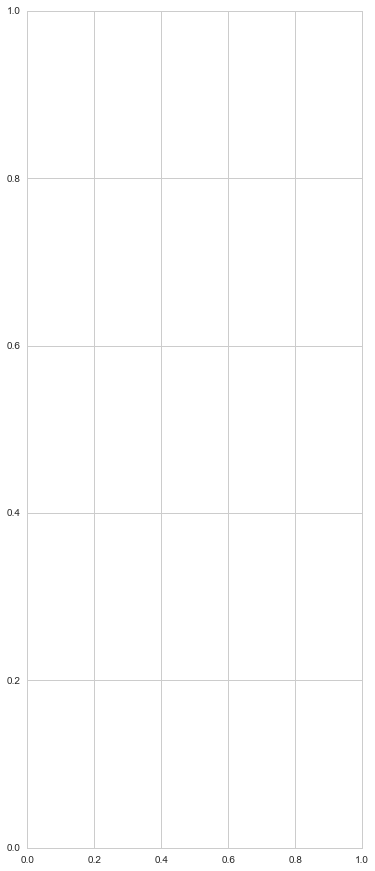

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

indc = ind_counts.values[0:15]
indnames = ind_counts.index[0:15]

df1 = pd.DataFrame({'indnames':ind_counts.index[0:15],'indc':ind_counts.values[0:15]})

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="indnames", y="indc", data=df, label="indc", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="center right", frameon=True)
ax.set(xlim=(0, 600), ylabel="",
       xlabel="Names and their counts")
#sns.despine(right=True, top=True)



In [84]:
t=df.groupby('industry').size().nlargest(10)

In [86]:
type(t)

pandas.core.series.Series

In [89]:
for ind in t.index:
    grouped.groupby('title').size().nlargest(10)

Index([u'higher education', u'research', u'computer software',
       u'information technology and services', u'hospital & health care',
       u'missing', u'marketing and advertising', u'financial services',
       u'education management', u'nonprofit organization management'],
      dtype='object', name=u'industry')

In [61]:
temp_df.title.value_counts()

missing                                                                                                                     63
Student at California Institute of Technology                                                                               11
Research Professional                                                                                                       10
Student at Wellesley College                                                                                                 9
--                                                                                                                           8
Postdoctoral Scholar at California Institute of Technology                                                                   8
Graduate Student at California Institute of Technology                                                                       8
Graduate Research Assistant at Georgia Institute of Technology                                                 

In [369]:
def get_ind_group(ind):
    ind = ind.strip().lower()
    ind_groups = { 'missing': 0,
                   'higher education': 1,
                   'research': 1,
                   'computer software': 2,
                   'information technology and services': 2,
                   'internet': 2,
                   'design': 2,
                   'mechanical or industrial engineering': 2,
                   'aviation aerospace': 2,
                   'electrical electronic manufacturing': 2,
                   'civil engineering': 2,
                   'telecommunications': 2,
                   'graphic design': 2,
                   'information services': 2,
                   'semiconductors': 2,
                   'computer hardware': 2,
                   'logistics and supply chain': 2,
                   'automotive': 2,
                   'program development': 2,
                   'computer games': 2,
                   'computer network security': 2,
                   'nanotechnology': 2,
                   'animation': 2,
                   'nanotechnologies': 2 }

    result = ind_groups.get(ind, 3)
    return result


In [370]:
df['ind_group'] = df['industry'].apply(lambda x:get_ind_group(x))

In [371]:
df.ind_group.value_counts()

3    20277
2     5634
1     4320
0     1184
Name: ind_group, dtype: int64

In [373]:
newdf = df[df['ind_group'] == 2]

In [374]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 0 to 31410
Data columns (total 16 columns):
first_name          5634 non-null object
full_name           5634 non-null object
html                5634 non-null object
industry            5634 non-null object
location            5634 non-null object
summary             5634 non-null object
title               5634 non-null object
counter             5634 non-null float64
source              5634 non-null object
full_name_fields    5634 non-null object
name_fields         5634 non-null int64
gender              5634 non-null object
gender_type         5634 non-null object
gender_forced       5634 non-null object
name_counts         5634 non-null int64
ind_group           5634 non-null int64
dtypes: float64(1), int64(3), object(12)
memory usage: 748.3+ KB


In [379]:
newdf.groupby('gender_forced').size()

gender_forced
female    1878
male      3756
dtype: int64

In [378]:
newdf['class'] = np.ones(len(newdf))

/Users/lekha/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [398]:
newdf['class'] = newdf['gender_forced'].apply(lambda x: 0 if x == 'female' else 1)

In [399]:
def f(x):
    if x == 'missing':
        return 1
    else:
        return 0



In [400]:
# add feature for num of words in the summary
def lenx(mystr):
    return len(mystr.split())

def avgchrs(mytokens):
    tw = len(mytokens)    
    num_chars = 0
    for word in mytokens:
        num_chars += len(word)
        
    return num_chars/tw

In [401]:
# Add feature for missing summary
newdf['summ_missing'] = newdf['summary'].apply(lambda x: f(x))

In [392]:
grp = newdf.groupby('gender')

In [394]:
newdf['summ_missing'].value_counts()

0    3648
1    1986
Name: summ_missing, dtype: int64

In [395]:
1436 +550

1986

In [393]:
grp[['summ_missing']].transform(sum)

,summ_missing
0,1436
23,550
31,550
55,550
57,1436
66,550
68,550
70,550
73,550
90,1436


In [403]:
newdf['summ_tokens'] = newdf['summary'].apply(lambda x: nltk.word_tokenize(str(x)))

In [404]:
newdf['num_tokens'] = newdf['summ_tokens'].apply(lambda x: len(x))

In [405]:
newdf['avg_len'] = newdf['summ_tokens'].apply(lambda x: avgchrs(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113e4f710>]], dtype=object)

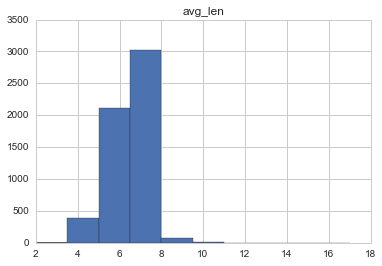

In [406]:
newdf.hist('avg_len')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1178b6f90>]], dtype=object)

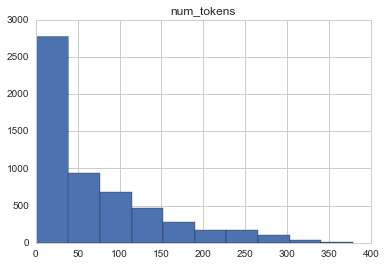

In [407]:
newdf.hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

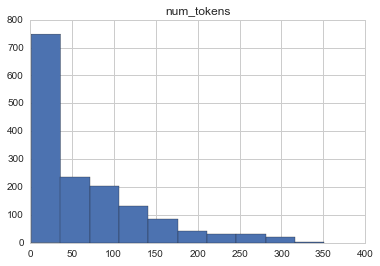

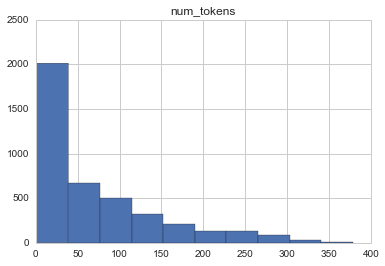

In [408]:
newdf.groupby('gender').hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

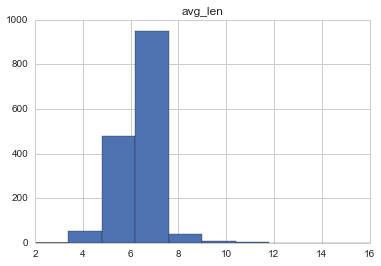

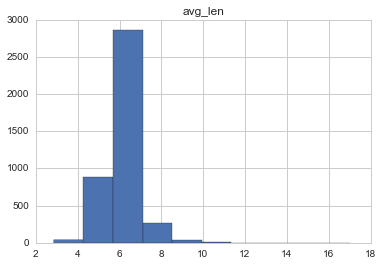

In [409]:
newdf.groupby('gender').hist('avg_len')

In [410]:
gender_group = newdf.groupby('gender')

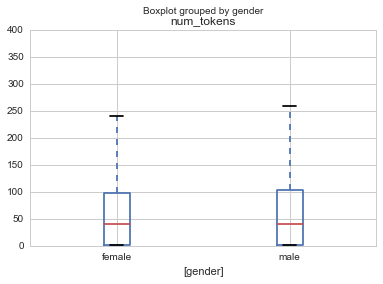

In [411]:
bp = newdf.boxplot(column=['num_tokens'], by=['gender'])

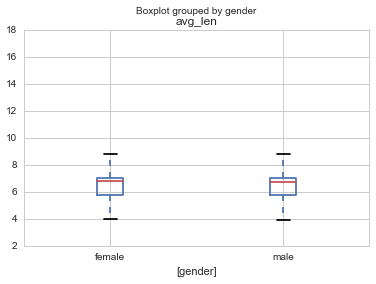

In [412]:
bp = newdf.boxplot(column=['avg_len'], by=['gender'])

In [ ]:
gender_group.describe().T

In [413]:
summ_missing = newdf.groupby('gender').agg({'summ_missing':sum})

In [414]:
sum_gender = newdf.groupby('gender').agg(np.sum)

In [415]:
avg_gender = newdf.groupby('gender').agg(np.mean)

In [416]:
avg_gender

,counter,name_fields,name_counts,ind_group,class,summ_missing,num_tokens,avg_len
gender,,,,,,,,
female,1,2.151990,15.789302,2,0.172211,0.358774,62.007175,6.441174
male,1,2.158742,40.546452,2,0.851500,0.350158,66.390880,6.402207


In [418]:
# Only include rows with summaries
newdf = newdf[newdf['summ_missing'] == 0]

In [419]:
# lexical diversity = number of unique tokens / total number of tokens
newdf['lex_diversity'] = newdf['summ_tokens'].apply(lambda x: len(set(x))/len(x))


In [420]:
newdf.head()

,first_name,full_name,html,industry,location,summary,title,counter,source,full_name_fields,...,gender_type,gender_forced,name_counts,ind_group,class,summ_missing,summ_tokens,num_tokens,avg_len,lex_diversity
0,aaron,aaron haesaert,../../data/raw/2015-12-23-holyoke/aaron-haesae...,design,"South Hadley, Massachusetts",as creative director aaron works with clients...,Creative Director at Mount Holyoke College,1,holyoke,"['aaron', 'haesaert']",...,male,male,1,2,1,0,"[as, creative, director, aaron, works, with, c...",147,5.333333,0.659864
31,aimee,aimee garn,../../data/raw/2015-12-23-holyoke/aimee-garn-1...,design,Greater New York City Area,for the past few decades i have been a journe...,Creative Journeyman,1,holyoke,"['aimee', 'garn']",...,female,female,2,2,0,0,"[for, the, past, few, decades, i, have, been, ...",79,5.379747,0.797468
55,alexana,alexana wirth,../../data/raw/2015-12-23-holyoke/alexandrawir...,mechanical or industrial engineering,"Portland, Maine",currently working towards a bs in mechanical ...,Mechanical Engineering Student at the Universi...,1,holyoke,"['alexana', 'wirth']",...,predicted,female,4,2,0,0,"[currently, working, towards, a, bs, in, mecha...",65,5.584615,0.800000
66,ali,ali aslam,../../data/raw/2015-12-23-holyoke/aliaslam.html,computer software,Greater Boston Area,seasoned software engineer with extensive exp...,Senior Software Engineer at Novetta,1,holyoke,"['ali', 'aslam']",...,male,male,4,2,1,0,"[seasoned, software, engineer, with, extensive...",146,6.095890,0.753425
68,ali,ali r khan,../../data/raw/2015-12-23-holyoke/khanalir.html,information technology and services,Greater Boston Area,\texperienced project program manager offerin...,Vice President at State Street,1,holyoke,"['ali', 'r', 'khan']",...,male,male,4,2,1,0,"[experienced, project, program, manager, offer...",138,6.956522,0.760870


gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

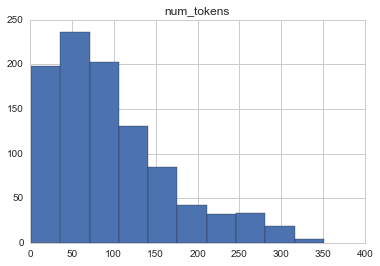

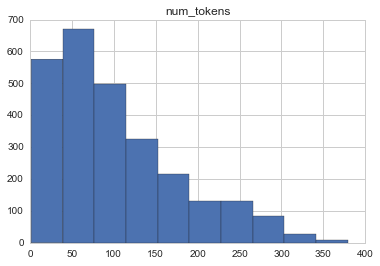

In [421]:
newdf.groupby('gender').hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

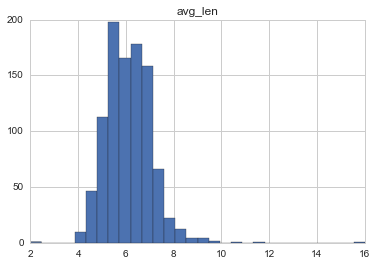

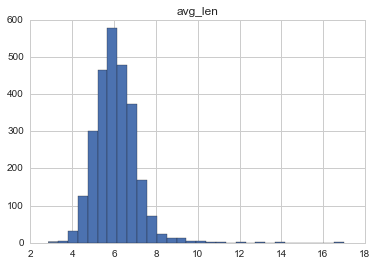

In [433]:
newdf.groupby('gender').hist('avg_len', bins=30)

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

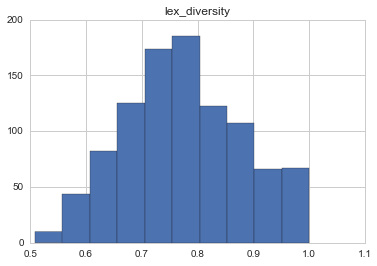

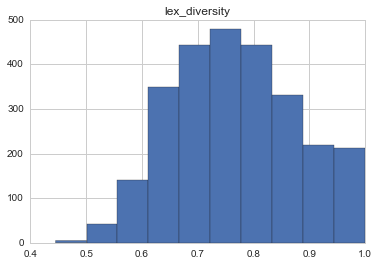

In [434]:
newdf.groupby('gender').hist('lex_diversity')

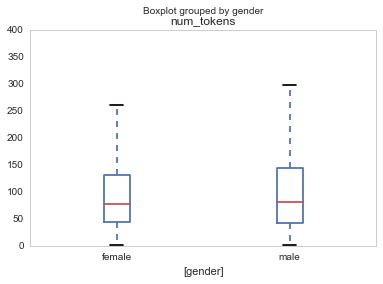

In [436]:
bp = newdf.boxplot(column=['num_tokens'], by=['gender'], grid=False)

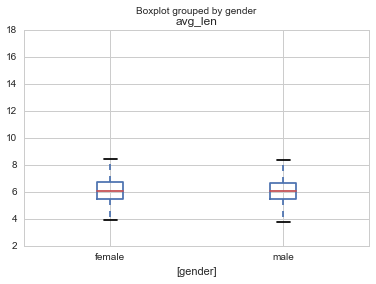

In [425]:
bp = newdf.boxplot(column=['avg_len'], by=['gender'])

In [427]:
# The breakdown by gender of the final dataset used for train and test
newdf.gender.value_counts()

male      2665
female     983
Name: gender, dtype: int64

In [429]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3648 entries, 0 to 31410
Data columns (total 22 columns):
first_name          3648 non-null object
full_name           3648 non-null object
html                3648 non-null object
industry            3648 non-null object
location            3648 non-null object
summary             3648 non-null object
title               3648 non-null object
counter             3648 non-null float64
source              3648 non-null object
full_name_fields    3648 non-null object
name_fields         3648 non-null int64
gender              3648 non-null object
gender_type         3648 non-null object
gender_forced       3648 non-null object
name_counts         3648 non-null int64
ind_group           3648 non-null int64
class               3648 non-null int64
summ_missing        3648 non-null int64
summ_tokens         3648 non-null object
num_tokens          3648 non-null int64
avg_len             3648 non-null float64
lex_diversity       3648 non-null f

# Basic Vocabulary Study

In [ ]:
females_df = df[df['gender']=='female']
males_df = df[df['gender'] =='male']

In [ ]:
def remove_digits(mystr):
    '''
    INPUT: list of tokens 
    OUTPUT: list of tokens with digits removed
    '''
    return [word for word in mystr if not word.isdigit()]
        

In [ ]:
def get_vocab(input_df):
    tokens_by_row = input_df['summ_tokens']
    vocab = []
    for row in tokens_by_row:
        row = remove_digits(row)
        for word in row:
            if word not in stopwords:
                vocab.append(word) 
    return vocab

In [ ]:
vocab = get_vocab(df)

In [ ]:
# freq distribution
freq_dist = nltk.FreqDist(vocab)
freq_dist.most_common(30)
freq_dist.plot(30)


In [ ]:
f_vocab = get_vocab(females_df)
m_vocab = get_vocab(males_df)

In [ ]:
m_freq_dist = nltk.FreqDist(m_vocab)
#freq_dist.N
m_freq_dist.most_common(30)
#freq_dist.freq('management')
m_freq_dist.plot(30)


In [ ]:
f_freq_dist = nltk.FreqDist(f_vocab)
#freq_dist.N
f_freq_dist.most_common(30)
#freq_dist.freq('management')
f_freq_dist.plot(30)


In [ ]:
print (f_freq_dist.freq('technology'))
print (m_freq_dist.freq('technology'))

# Predict gender using summary using RF - Baseline Model

In [ ]:
df['summary'] = df['summary'].astype(str)

In [ ]:
df.set_value(31431, 'first_name', 'nanname')
df.set_value(31432, 'first_name', 'nanname')
df.set_value(31433, 'first_name', 'nanname')
df.set_value(31434, 'first_name', 'nanname')
df.set_value(31431, 'gender', 'female')
df.set_value(31432, 'gender', 'female')
df.set_value(31433, 'gender', 'female')
df.set_value(31434, 'gender', 'female')

In [ ]:
# Check for any nans in the DF
df[pd.isnull(df).any(axis=1)]


In [ ]:
from nltk import word_tokenize          
import pdb
stemmer = SnowballStemmer("english")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return stems

def tokenize_no_stem(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return tokens    

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['summary'], df['class'], test_size=0.3, random_state=0)

In [ ]:
temp = np.array(y_test)
len(temp[(temp == 0)])

In [ ]:
print ("Creating the bag of words...\n")
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = tokenize_no_stem,    \
                             preprocessor = None, \
                             stop_words = stopwords,   \
                             max_features = 5000) 

In [ ]:
tfidf = TfidfVectorizer(analyzer = 'word', tokenizer = tokenize_no_stem, stop_words = stopwords, max_features = 5000)

In [ ]:
train_tfidf = tfidf.fit_transform(X_train)

In [ ]:
X_train.shape

In [ ]:
train_tfidf = train_tfidf.toarray()
feature_names_tfidf = tfidf.get_feature_names()

In [ ]:
feature_names_tfidf[1]

In [ ]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_countv = vectorizer.fit_transform(X_train)

In [ ]:
# Numpy arrays are easy to work with, so convert the result to an 
# array
train_countv= train_countv.toarray()
feature_names_countv = vectorizer.get_feature_names()

In [ ]:
# Take a look at the words in the vocabulary
print (feature_names_countv)

In [ ]:
print ("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest_cv = forest.fit(train_countv, y_train)

forest_tfidf = forest.fit(train_tfidf, y_train)

In [ ]:
forest_cv

In [ ]:
# Testing

# Get a bag of words for the test set, and convert to a numpy array
#test_data_features = vectorizer.transform(X_test)
test_features_tfidf = tfidf.transform(X_test)
test_features_tfidf = test_features_tfidf.toarray()

# Use the random forest to make sentiment label predictions
yhat = forest_tfidf.predict(test_features_tfidf)
probX = forest_tfidf.predict_proba(test_features_tfidf)


In [ ]:
acc = forest.score(test_features_tfidf, y_test)

In [ ]:
acc

In [ ]:
yhat.shape

In [ ]:
print ("Precision Score: {0}".format(precision_score(y_test, yhat)))
print ("Recall Score: {0}".format(recall_score(y_test, yhat)))
print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat)))
print ("Model Score:{0}".format(forest.score(test_features_tfidf, y_test)))

In [ ]:
# print ("Precision Score: {0}".format(precision_score(y_test, yhat1)))
# print ("Recall Score: {0}".format(recall_score(y_test, yhat1)))
# print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat1)))
# print ("Model Score:{0}".format(forest.score(test_data_features, y_test)))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probX[:,1])

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probX[:,1])

In [ ]:
fpr2, tpr2, thresholds2 = roc_curve(y_test, probX[:,1])

In [ ]:
thresholds[1:10]

In [ ]:
# ROC Curve
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.array(range(101))/100, np.array(range(101))/100, '--', color='black')
plt.plot(fpr, tpr, label='rf-tfidf')
#plt.plot(fpr1, tpr1, label='rf-stemmed')
#plt.plot(fpr2, tpr2, label='rf-tfidf')
plt.ylabel("True Positive Rate ")
plt.xlabel("False Positive Rate")
plt.title("ROC plot")
plt.legend(loc='lower right')

plt.grid()
plt.show()



In [ ]:
df['summary'].values

In [ ]:
# Most important features
num = 50
imp = forest.feature_importances_
feature_names = np.array(feature_names_tfidf)
features = feature_names[np.argsort(imp)[-num:]]
weights = imp[np.argsort(imp)[-num:]]
feats_with_vals = zip(features, weights)
for x in feats_with_vals:
    print (x)


# Topic Modeling with 5000 features: NMF

### 1. All profiles

In [ ]:
females = df[df['gender'] == 'female']
males = df[df['gender'] == 'male']

In [ ]:
X = df['summ_tokens']
y = np.array(df['class'])

In [ ]:
# Print the top 20 words and weights for each topic
def print_top_weights(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        #print (top_weights)
        print (" ".join(["{0}, {1}".format(feature_names[x], topic[x]) for x in top_weights]))
    print()
    

# Print the most probable topic for each document/profile
def profiles_by_topic(W):
    top_idx = np.zeros([W.shape[0],1], dtype=float)
    for row_idx, row in enumerate(W):
        topic_idx = row.argsort()[-1]  
        top_idx[row_idx] = topic_idx
    topics, counts = np.unique(top_idx, return_counts=True)
    print (np.asarray((topics, counts)).T)
    return top_idx

In [ ]:
#tokenize: function that is stemming using SnowballStemmer
def run_topic_model_tfidf(X, stopwords):
    print ("Bag of Words, Tfidf\n")
    
    vectorizer = TfidfVectorizer(analyzer = 'word', tokenizer = tokenize_no_stem, stop_words = stopwords, max_features = 5000)
    word_frequencies = vectorizer.fit_transform(X)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    word_frequencies = word_frequencies.toarray()
    feature_names = vectorizer.get_feature_names()

    # NMF Model to determine topics
    nmf_model = NMF(n_components=7, init='random', random_state=0)
    W = nmf_model.fit_transform(word_frequencies)
    # H: Topics * Words
    H = nmf_model.components_
    print (H.shape, W.shape)
    
    n_top_words = 20
    # Print weights and topics for the top 20 topics
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        print (" ".join(["{0}".format(feature_names[x]) for x in top_weights]))
    print()
    
    # Highest Weighted Topic for each profile
    print ("Number of profiles by topic\n")
    top_idx = profiles_by_topic(W) 
    
    return nmf_model, W, top_idx

In [ ]:
#tokenize: function that is stemming using SnowballStemmer
#stopwords: custom stop words
def run_topic_model_countv(X, stopwords):
    print ("Bag of words, Count Vectorizer...\n")
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = tokenize_no_stem,    \
                                 preprocessor = None, \
                                 stop_words = stopwords,   \
                                 max_features = 5000) 


    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings.
    word_frequencies = vectorizer.fit_transform(X)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    word_frequencies = word_frequencies.toarray()
    feature_names = vectorizer.get_feature_names()

    # NMF Model to determine topics
    nmf_model = NMF(n_components=10, init='random', random_state=0)
    W = nmf_model.fit_transform(word_frequencies)
    # H: Topics * Words
    H = nmf_model.components_
    print (H.shape, W.shape)
    
    n_top_words = 20
    # Print weights and topics for the top 20 topics
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        #print (" ".join(["{0}".format(feature_names[x]) for x in top_weights]))
        print (" ".join(["{0}, {1}".format(feature_names[x], topic[x]) for x in top_weights]))
    print()
    
    print ("Number of profiles by Topic\n")
    top_idx = profiles_by_topic(W)
    
    print ("Example Profiles by Topic\n")
    
    
    return nmf_model, W, top_idx

# Topics for Female Profiles - TFIDF

In [ ]:
X = females['summary']
y = np.array(females['class'])

nmf_model, W, top_idx = run_topic_model_tfidf(X, stopwords)


# Female Topics - Count Vectorizer

In [ ]:
X = females['summary']
y = np.array(females['class'])

nmf_model, W, top_idx = run_topic_model_countv(X, stopwords)



# Topics for Male Profiles - TFIDF

In [ ]:
X = males['summary']
y = np.array(males['class'])

nmf_model, W, top_idx = run_topic_model_tfidf(X, stopwords)


# Male Topics - CountVectorizer

In [ ]:
X = males['summary']
y = np.array(males['class'])

nmf_model, W, top_idx = run_topic_model_countv(X, stopwords)

In [ ]:
# Number of profiles clustered by topic number
# Do this again after stemming

In [ ]:
top_idx[1:10]

In [ ]:
males.ix[0]['summary'] # Topic 3

In [ ]:
males.ix[1]['summary'] # Topic 4

In [ ]:
males.ix[4]['summary'] # Topic 9

In [ ]:
# Generating a word cloud:
#https://github.com/amueller/word_cloud/blob/master/examples/simple.py
    
from os import path
from wordcloud import WordCloud

d = path.dirname(__file__)

# Read the whole text.
text = open(path.join(d, 'constitution.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#http://stanford.edu/~mwaskom/software/seaborn/examples/grouped_boxplot.html
import seaborn as sns
sns.set(style="ticks")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="day", y="total_bill", hue="sex", data=tips, palette="PRGn")
sns.despine(offset=10, trim=True)

In [430]:
770000/3900

197.43589743589743

In [431]:
200*10

2000

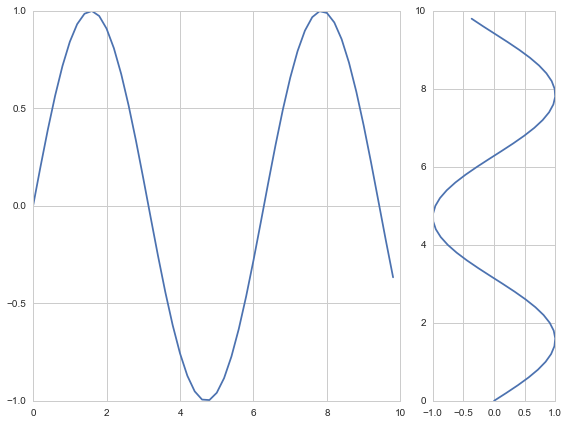

In [435]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec

# generate some data
x = np.arange(0, 10, 0.2)
y = np.sin(x)

# plot it
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.plot(x, y)
ax1 = plt.subplot(gs[1])
ax1.plot(y, x)

plt.tight_layout()
plt.savefig('grid_figure.pdf')